# Convolutional Neural Network

The last method we cover, is the convolutional neural network. We have chosen to implement the CNN called LeNet. LeNet has the structure below. LeNet takes a 28x28 greyscale image, and runs it sequentially through two convolution layers (each consisting of a convolution, an activation function and a pooling layer.). The second convolutional layer feeds the output to a fully connected neural network. In our implementation, we output to 5 classes only. We also introduce a dropout layer after the first fully connected layer. This prevents overfitting. Furthermore we also do early stopping to prevent overfitting on the training dataset.


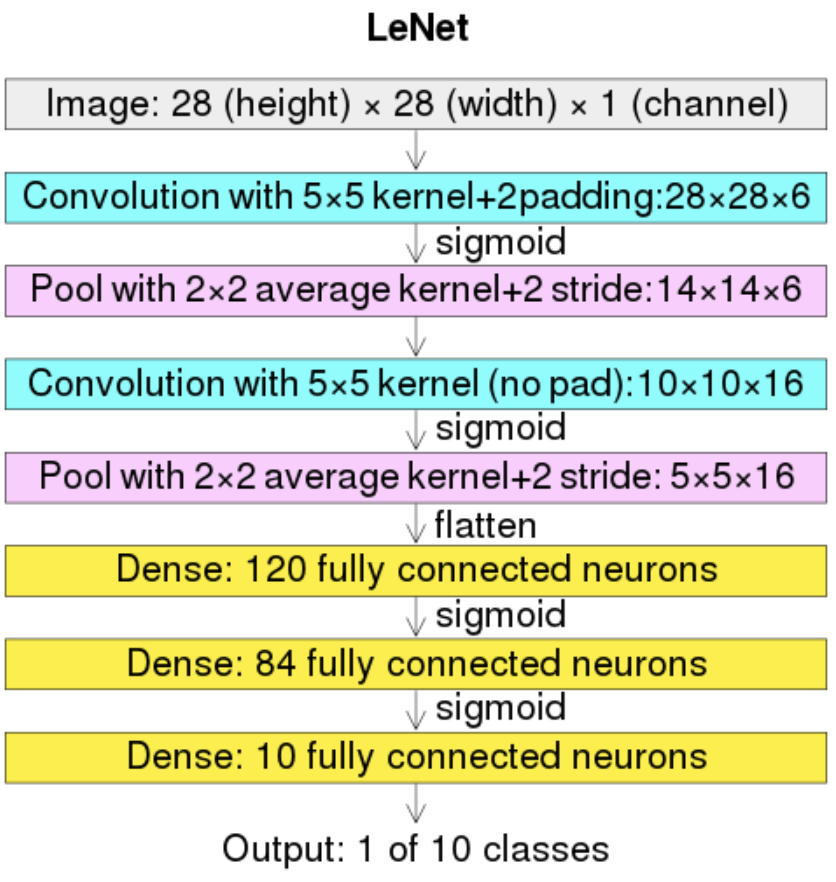

In [1]:
# Libaries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


sns.set_style("darkgrid")

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.utils.data
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torchinfo import summary
import torchvision



from sklearn.metrics import *


In [2]:
# Load data

train_data = np.load("data/fashion_train.npy")
X_train, y_train = train_data[:,:784] / 255, train_data[:,-1]

test_data = np.load("data/fashion_test.npy")
X_test, y_test = test_data[:,:784] / 255, test_data[:,-1]

N_CLASSES = len(np.unique(y_train))
CLOTHING_TYPES = {0: "T-shirt/top", 
                  1: "Trouser",
                  2: "Pullover",
                  3: "Dress",
                  4: "Shirt"}


To allow early stopping, we split the dataset into training, validation and test dataset. These consist of 53.3%, 13.3% and 33.3%

In [3]:
cnn_X_train = X_train.reshape(-1,28,28)
X_tensor = torch.from_numpy(cnn_X_train).float().unsqueeze(1)
y_tensor = torch.from_numpy(y_train).long()
cnn_train_data = TensorDataset(X_tensor, y_tensor)

cnn_X_test = X_test.reshape(-1,28,28)
X_test_tensor = torch.from_numpy(cnn_X_test).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).long()
cnn_test_data = TensorDataset(X_test_tensor, y_test_tensor)

cnn_train_data, cnn_validation_data = torch.utils.data.random_split(cnn_train_data, [8000, 2000]) 

In [4]:
# We create a dataloader for train and test
BATCH_SIZE = 128

loaders = {
    'train' : DataLoader(cnn_train_data,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1),
        
    'validation'  : DataLoader(cnn_validation_data, 
                                          batch_size=BATCH_SIZE,
                                          num_workers=1,
                                          ),

    'test'  : DataLoader(cnn_test_data, 
                                          batch_size=BATCH_SIZE, 
                                          num_workers=1,
                                          )
}


In [21]:
# We define the LeNet

class CNN(nn.Module):
    def __init__(self):
        self.training_loss = []
        self.validation_loss = []
        self.n_epochs = 0

        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6, kernel_size=5, padding=2), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2)
        )

        self.fully_connected = nn.Sequential(
            # FFNN Layer 1
            nn.Linear(in_features=16*5*5,out_features=120), 
            nn.Sigmoid(),
            nn.Dropout(p=0.2),

            # FFNN Layer 2
            nn.Linear(in_features=120,out_features=84), 
            nn.Sigmoid(),
            
            # FFNN Output layer
            nn.Linear(in_features=84,out_features=N_CLASSES) 
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.fully_connected(x)
        return output
    
    def plot_loss(self):
        sns.lineplot(x=[i for i in range(1,self.n_epochs + 1)], y=self.training_loss, marker='o',color="red",label='Training loss')
        sns.lineplot(x=[i for i in range(1,self.n_epochs + 1)], y=self.validation_loss,marker='o', color="blue", label='Validation loss')
        plt.legend()
        plt.suptitle("Training and validation loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.tight_layout()


def train(n_epochs, ann, loaders, learning_rate=0.05):
    ann.n_epochs = n_epochs
    ann.validation_loss = []
    ann.training_loss = []
    min_valid_loss = np.inf
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    ann.to(device)

    for epoch in tqdm(range(n_epochs)):
        epoch_train_loss = 0
        ann.train()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(ann.parameters(), lr=learning_rate)

        for i, (images, labels) in enumerate(loaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            output = ann(images)

            loss = loss_fn(output, labels)
            epoch_train_loss += loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        epoch_val_loss = 0
        ann.eval()

        for images_v, labels_v in loaders['validation']:
            images_v, labels_v = images_v.to(device), labels_v.to(device)

            output = ann(images_v)
            loss_v = loss_fn(output, labels_v)
            epoch_val_loss += loss_v.item()
        
        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
        print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')

        ann.validation_loss.append(epoch_val_loss / len(loaders["validation"]))
        ann.training_loss.append(epoch_train_loss / len(loaders["train"]))

        print('-------------------')
        if min_valid_loss > epoch_val_loss:
            print(f'Validation Loss Decreased({min_valid_loss/ len(loaders["validation"])}--->{epoch_val_loss/ len(loaders["validation"])}) \t Saving The Model')
            min_valid_loss = epoch_val_loss
          # Saving State Dict
            torch.save(ann.state_dict(), 'data/saved_model.pth')






In [29]:
# initialise it
conv_nn = CNN()

summary(conv_nn,input_size=[8000,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [8000, 5]                 --
├─Sequential: 1-1                        [8000, 6, 14, 14]         --
│    └─Conv2d: 2-1                       [8000, 6, 28, 28]         156
│    └─Sigmoid: 2-2                      [8000, 6, 28, 28]         --
│    └─AvgPool2d: 2-3                    [8000, 6, 14, 14]         --
├─Sequential: 1-2                        [8000, 16, 5, 5]          --
│    └─Conv2d: 2-4                       [8000, 16, 10, 10]        2,416
│    └─Sigmoid: 2-5                      [8000, 16, 10, 10]        --
│    └─AvgPool2d: 2-6                    [8000, 16, 5, 5]          --
├─Sequential: 1-3                        [8000, 5]                 --
│    └─Linear: 2-7                       [8000, 120]               48,120
│    └─Sigmoid: 2-8                      [8000, 120]               --
│    └─Dropout: 2-9                      [8000, 120]               --
│    └─

In [30]:
train(100, conv_nn, loaders, 0.005)


  1%|          | 1/100 [00:02<04:07,  2.50s/it]

Epoch 1
Training Loss: 1.6163320352160742
Validation Loss: 1.5802276283502579
-------------------
Validation Loss Decreased(inf--->1.5802276283502579) 	 Saving The Model


  2%|▏         | 2/100 [00:04<03:54,  2.39s/it]

Epoch 2
Training Loss: 1.1734632102269975
Validation Loss: 0.9414271004498005
-------------------
Validation Loss Decreased(1.5802276283502579--->0.9414271004498005) 	 Saving The Model


  3%|▎         | 3/100 [00:07<03:49,  2.37s/it]

Epoch 3
Training Loss: 0.8896315656011067
Validation Loss: 0.8008493185043335
-------------------
Validation Loss Decreased(0.9414271004498005--->0.8008493185043335) 	 Saving The Model


  4%|▍         | 4/100 [00:09<03:52,  2.42s/it]

Epoch 4
Training Loss: 0.812300807899899
Validation Loss: 0.7525127194821835
-------------------
Validation Loss Decreased(0.8008493185043335--->0.7525127194821835) 	 Saving The Model


  5%|▌         | 5/100 [00:12<03:52,  2.44s/it]

Epoch 5
Training Loss: 0.7514157938578773
Validation Loss: 0.6817317605018616
-------------------
Validation Loss Decreased(0.7525127194821835--->0.6817317605018616) 	 Saving The Model


  6%|▌         | 6/100 [00:14<03:46,  2.41s/it]

Epoch 6
Training Loss: 0.6646859059258113
Validation Loss: 0.608901996165514
-------------------
Validation Loss Decreased(0.6817317605018616--->0.608901996165514) 	 Saving The Model


  7%|▋         | 7/100 [00:16<03:42,  2.39s/it]

Epoch 7
Training Loss: 0.6017802376595754
Validation Loss: 0.5780168976634741
-------------------
Validation Loss Decreased(0.608901996165514--->0.5780168976634741) 	 Saving The Model


  8%|▊         | 8/100 [00:19<03:40,  2.40s/it]

Epoch 8
Training Loss: 0.5637715823120542
Validation Loss: 0.5434755422174931
-------------------
Validation Loss Decreased(0.5780168976634741--->0.5434755422174931) 	 Saving The Model


  9%|▉         | 9/100 [00:21<03:36,  2.38s/it]

Epoch 9
Training Loss: 0.5457669099171957
Validation Loss: 0.5370873212814331
-------------------
Validation Loss Decreased(0.5434755422174931--->0.5370873212814331) 	 Saving The Model


 10%|█         | 10/100 [00:23<03:32,  2.36s/it]

Epoch 10
Training Loss: 0.5219711893134646
Validation Loss: 0.5447520725429058
-------------------


 11%|█         | 11/100 [00:26<03:29,  2.36s/it]

Epoch 11
Training Loss: 0.5066235221567608
Validation Loss: 0.5187715068459511
-------------------
Validation Loss Decreased(0.5370873212814331--->0.5187715068459511) 	 Saving The Model


 12%|█▏        | 12/100 [00:28<03:33,  2.42s/it]

Epoch 12
Training Loss: 0.4895687467522091
Validation Loss: 0.49772116355597973
-------------------
Validation Loss Decreased(0.5187715068459511--->0.49772116355597973) 	 Saving The Model


 13%|█▎        | 13/100 [00:31<03:32,  2.45s/it]

Epoch 13
Training Loss: 0.4705229467815823
Validation Loss: 0.47251767478883266
-------------------
Validation Loss Decreased(0.49772116355597973--->0.47251767478883266) 	 Saving The Model


 14%|█▍        | 14/100 [00:33<03:27,  2.41s/it]

Epoch 14
Training Loss: 0.4580286665568276
Validation Loss: 0.48436576314270496
-------------------


 15%|█▌        | 15/100 [00:35<03:22,  2.39s/it]

Epoch 15
Training Loss: 0.4478749173974234
Validation Loss: 0.47937790118157864
-------------------


 16%|█▌        | 16/100 [00:38<03:19,  2.38s/it]

Epoch 16
Training Loss: 0.4397096695407989
Validation Loss: 0.4649904929101467
-------------------
Validation Loss Decreased(0.47251767478883266--->0.4649904929101467) 	 Saving The Model


 17%|█▋        | 17/100 [00:40<03:16,  2.37s/it]

Epoch 17
Training Loss: 0.4335553428483388
Validation Loss: 0.4429478980600834
-------------------
Validation Loss Decreased(0.4649904929101467--->0.4429478980600834) 	 Saving The Model


 18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]

Epoch 18
Training Loss: 0.417117791989493
Validation Loss: 0.4339476954191923
-------------------
Validation Loss Decreased(0.4429478980600834--->0.4339476954191923) 	 Saving The Model


 19%|█▉        | 19/100 [00:45<03:11,  2.36s/it]

Epoch 19
Training Loss: 0.41073146036693026
Validation Loss: 0.43227539770305157
-------------------
Validation Loss Decreased(0.4339476954191923--->0.43227539770305157) 	 Saving The Model


 20%|██        | 20/100 [00:47<03:08,  2.35s/it]

Epoch 20
Training Loss: 0.3980317631411174
Validation Loss: 0.4302114527672529
-------------------
Validation Loss Decreased(0.43227539770305157--->0.4302114527672529) 	 Saving The Model


 21%|██        | 21/100 [00:50<03:04,  2.34s/it]

Epoch 21
Training Loss: 0.3976520522246285
Validation Loss: 0.401844535022974
-------------------
Validation Loss Decreased(0.4302114527672529--->0.401844535022974) 	 Saving The Model


 22%|██▏       | 22/100 [00:52<03:02,  2.34s/it]

Epoch 22
Training Loss: 0.3894150498367491
Validation Loss: 0.4148277211934328
-------------------


 23%|██▎       | 23/100 [00:54<03:00,  2.34s/it]

Epoch 23
Training Loss: 0.3764827275086963
Validation Loss: 0.39994819834828377
-------------------
Validation Loss Decreased(0.401844535022974--->0.39994819834828377) 	 Saving The Model


 24%|██▍       | 24/100 [00:57<02:58,  2.34s/it]

Epoch 24
Training Loss: 0.3725352471783048
Validation Loss: 0.3777435626834631
-------------------
Validation Loss Decreased(0.39994819834828377--->0.3777435626834631) 	 Saving The Model


 25%|██▌       | 25/100 [00:59<02:55,  2.34s/it]

Epoch 25
Training Loss: 0.3657364048182018
Validation Loss: 0.3965984731912613
-------------------


 26%|██▌       | 26/100 [01:01<02:54,  2.35s/it]

Epoch 26
Training Loss: 0.3595597521653251
Validation Loss: 0.3848531488329172
-------------------


 27%|██▋       | 27/100 [01:04<02:52,  2.36s/it]

Epoch 27
Training Loss: 0.34483792384465534
Validation Loss: 0.38389680348336697
-------------------


 28%|██▊       | 28/100 [01:06<02:50,  2.36s/it]

Epoch 28
Training Loss: 0.34743259397764054
Validation Loss: 0.3746903594583273
-------------------
Validation Loss Decreased(0.3777435626834631--->0.3746903594583273) 	 Saving The Model


 29%|██▉       | 29/100 [01:08<02:47,  2.36s/it]

Epoch 29
Training Loss: 0.338905468583107
Validation Loss: 0.3726427089422941
-------------------
Validation Loss Decreased(0.3746903594583273--->0.3726427089422941) 	 Saving The Model


 30%|███       | 30/100 [01:11<02:44,  2.35s/it]

Epoch 30
Training Loss: 0.33167951329359935
Validation Loss: 0.3628592398017645
-------------------
Validation Loss Decreased(0.3726427089422941--->0.3628592398017645) 	 Saving The Model


 31%|███       | 31/100 [01:13<02:41,  2.34s/it]

Epoch 31
Training Loss: 0.32051021735819557
Validation Loss: 0.35682934522628784
-------------------
Validation Loss Decreased(0.3628592398017645--->0.35682934522628784) 	 Saving The Model


 32%|███▏      | 32/100 [01:15<02:38,  2.34s/it]

Epoch 32
Training Loss: 0.3208389681956125
Validation Loss: 0.3628018368035555
-------------------


 33%|███▎      | 33/100 [01:18<02:36,  2.34s/it]

Epoch 33
Training Loss: 0.3146229348485432
Validation Loss: 0.3569225752726197
-------------------


 34%|███▍      | 34/100 [01:20<02:35,  2.35s/it]

Epoch 34
Training Loss: 0.30736582667108564
Validation Loss: 0.37042480893433094
-------------------


 35%|███▌      | 35/100 [01:22<02:33,  2.36s/it]

Epoch 35
Training Loss: 0.3034216357128961
Validation Loss: 0.3651914782822132
-------------------


 36%|███▌      | 36/100 [01:25<02:30,  2.36s/it]

Epoch 36
Training Loss: 0.30016530198710306
Validation Loss: 0.3499830747023225
-------------------
Validation Loss Decreased(0.35682934522628784--->0.3499830747023225) 	 Saving The Model


 37%|███▋      | 37/100 [01:27<02:28,  2.36s/it]

Epoch 37
Training Loss: 0.28986071286693454
Validation Loss: 0.39344685710966587
-------------------


 38%|███▊      | 38/100 [01:30<02:25,  2.35s/it]

Epoch 38
Training Loss: 0.2878405801833622
Validation Loss: 0.3610491771250963
-------------------


 39%|███▉      | 39/100 [01:32<02:23,  2.35s/it]

Epoch 39
Training Loss: 0.28271853427092236
Validation Loss: 0.3661967637017369
-------------------


 40%|████      | 40/100 [01:34<02:22,  2.37s/it]

Epoch 40
Training Loss: 0.28216711183389026
Validation Loss: 0.35085653606802225
-------------------


 41%|████      | 41/100 [01:37<02:19,  2.36s/it]

Epoch 41
Training Loss: 0.27534209428325535
Validation Loss: 0.3547559380531311
-------------------


 42%|████▏     | 42/100 [01:39<02:16,  2.36s/it]

Epoch 42
Training Loss: 0.2723372834069388
Validation Loss: 0.34002994280308485
-------------------
Validation Loss Decreased(0.3499830747023225--->0.34002994280308485) 	 Saving The Model


 43%|████▎     | 43/100 [01:41<02:14,  2.35s/it]

Epoch 43
Training Loss: 0.2672412409668877
Validation Loss: 0.3362203920260072
-------------------
Validation Loss Decreased(0.34002994280308485--->0.3362203920260072) 	 Saving The Model


 44%|████▍     | 44/100 [01:44<02:12,  2.36s/it]

Epoch 44
Training Loss: 0.26527828474839527
Validation Loss: 0.3387763574719429
-------------------


 45%|████▌     | 45/100 [01:46<02:10,  2.38s/it]

Epoch 45
Training Loss: 0.259657263519272
Validation Loss: 0.34684676211327314
-------------------


 46%|████▌     | 46/100 [01:48<02:08,  2.37s/it]

Epoch 46
Training Loss: 0.2573661241266463
Validation Loss: 0.3351473147049546
-------------------
Validation Loss Decreased(0.3362203920260072--->0.3351473147049546) 	 Saving The Model


 47%|████▋     | 47/100 [01:51<02:05,  2.36s/it]

Epoch 47
Training Loss: 0.24583084219031864
Validation Loss: 0.359053211286664
-------------------


 48%|████▊     | 48/100 [01:53<02:03,  2.37s/it]

Epoch 48
Training Loss: 0.2409007265454247
Validation Loss: 0.35803138371557
-------------------


 49%|████▉     | 49/100 [01:56<02:01,  2.38s/it]

Epoch 49
Training Loss: 0.25119841808364507
Validation Loss: 0.37902186159044504
-------------------


 50%|█████     | 50/100 [01:58<01:59,  2.39s/it]

Epoch 50
Training Loss: 0.24128500892529411
Validation Loss: 0.3497721999883652
-------------------


 51%|█████     | 51/100 [02:00<01:56,  2.38s/it]

Epoch 51
Training Loss: 0.2382940405181476
Validation Loss: 0.3335279216989875
-------------------
Validation Loss Decreased(0.3351473147049546--->0.3335279216989875) 	 Saving The Model


 52%|█████▏    | 52/100 [02:03<01:53,  2.37s/it]

Epoch 52
Training Loss: 0.23271814532696256
Validation Loss: 0.3517975118011236
-------------------


 53%|█████▎    | 53/100 [02:05<01:51,  2.37s/it]

Epoch 53
Training Loss: 0.22819862692129045
Validation Loss: 0.36035601515322924
-------------------


 54%|█████▍    | 54/100 [02:08<01:49,  2.38s/it]

Epoch 54
Training Loss: 0.22432971166239846
Validation Loss: 0.3530548233538866
-------------------


 55%|█████▌    | 55/100 [02:10<01:48,  2.41s/it]

Epoch 55
Training Loss: 0.22689713301166656
Validation Loss: 0.3609860558062792
-------------------


 56%|█████▌    | 56/100 [02:12<01:46,  2.41s/it]

Epoch 56
Training Loss: 0.21787179379709185
Validation Loss: 0.36127602495253086
-------------------


 57%|█████▋    | 57/100 [02:15<01:43,  2.40s/it]

Epoch 57
Training Loss: 0.211693631278144
Validation Loss: 0.3511682413518429
-------------------


 58%|█████▊    | 58/100 [02:17<01:39,  2.38s/it]

Epoch 58
Training Loss: 0.21633724300634294
Validation Loss: 0.34905759524554014
-------------------


 59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]

Epoch 59
Training Loss: 0.21286260939779736
Validation Loss: 0.36598913185298443
-------------------


 60%|██████    | 60/100 [02:22<01:35,  2.38s/it]

Epoch 60
Training Loss: 0.2099736180333864
Validation Loss: 0.3680884474888444
-------------------


 61%|██████    | 61/100 [02:24<01:32,  2.38s/it]

Epoch 61
Training Loss: 0.20193044108057778
Validation Loss: 0.3547021970152855
-------------------


 62%|██████▏   | 62/100 [02:27<01:31,  2.42s/it]

Epoch 62
Training Loss: 0.19751549453016312
Validation Loss: 0.36166450195014477
-------------------


 63%|██████▎   | 63/100 [02:29<01:28,  2.40s/it]

Epoch 63
Training Loss: 0.20161853825289106
Validation Loss: 0.36252121813595295
-------------------


 64%|██████▍   | 64/100 [02:31<01:25,  2.38s/it]

Epoch 64
Training Loss: 0.1995787459706503
Validation Loss: 0.35138016287237406
-------------------


 65%|██████▌   | 65/100 [02:34<01:23,  2.39s/it]

Epoch 65
Training Loss: 0.19710441359451839
Validation Loss: 0.3670111298561096
-------------------


 66%|██████▌   | 66/100 [02:36<01:20,  2.38s/it]

Epoch 66
Training Loss: 0.19370613696556244
Validation Loss: 0.36559196561574936
-------------------


 67%|██████▋   | 67/100 [02:39<01:18,  2.37s/it]

Epoch 67
Training Loss: 0.1879973312218984
Validation Loss: 0.36271200329065323
-------------------


 68%|██████▊   | 68/100 [02:41<01:15,  2.37s/it]

Epoch 68
Training Loss: 0.18747001366009788
Validation Loss: 0.3697974821552634
-------------------


 69%|██████▉   | 69/100 [02:43<01:13,  2.36s/it]

Epoch 69
Training Loss: 0.18386290151448476
Validation Loss: 0.36233084090054035
-------------------


 70%|███████   | 70/100 [02:46<01:11,  2.38s/it]

Epoch 70
Training Loss: 0.1911018741509271
Validation Loss: 0.3612250564619899
-------------------


 71%|███████   | 71/100 [02:48<01:08,  2.38s/it]

Epoch 71
Training Loss: 0.1792124645814063
Validation Loss: 0.4153887117281556
-------------------


 72%|███████▏  | 72/100 [02:51<01:07,  2.42s/it]

Epoch 72
Training Loss: 0.1721610870981027
Validation Loss: 0.35411151871085167
-------------------


 73%|███████▎  | 73/100 [02:53<01:05,  2.44s/it]

Epoch 73
Training Loss: 0.16433405142927926
Validation Loss: 0.3706797268241644
-------------------


 74%|███████▍  | 74/100 [02:55<01:03,  2.44s/it]

Epoch 74
Training Loss: 0.1702454708634861
Validation Loss: 0.3860977590084076
-------------------


 75%|███████▌  | 75/100 [02:58<01:01,  2.45s/it]

Epoch 75
Training Loss: 0.16617064509126875
Validation Loss: 0.3775763623416424
-------------------


 76%|███████▌  | 76/100 [03:01<00:59,  2.50s/it]

Epoch 76
Training Loss: 0.1685352229646274
Validation Loss: 0.39674348942935467
-------------------


 77%|███████▋  | 77/100 [03:03<00:56,  2.47s/it]

Epoch 77
Training Loss: 0.16235154169419455
Validation Loss: 0.37507548555731773
-------------------


 78%|███████▊  | 78/100 [03:05<00:53,  2.45s/it]

Epoch 78
Training Loss: 0.15784021608886264
Validation Loss: 0.3816805202513933
-------------------


 79%|███████▉  | 79/100 [03:08<00:51,  2.47s/it]

Epoch 79
Training Loss: 0.1509919645530837
Validation Loss: 0.3860555049031973
-------------------


 80%|████████  | 80/100 [03:10<00:49,  2.47s/it]

Epoch 80
Training Loss: 0.15403368040209725
Validation Loss: 0.38756751362234354
-------------------


 81%|████████  | 81/100 [03:13<00:47,  2.48s/it]

Epoch 81
Training Loss: 0.14485314577108338
Validation Loss: 0.40408793836832047
-------------------


 82%|████████▏ | 82/100 [03:15<00:44,  2.47s/it]

Epoch 82
Training Loss: 0.1537261503556418
Validation Loss: 0.40646063163876534
-------------------


 83%|████████▎ | 83/100 [03:18<00:41,  2.43s/it]

Epoch 83
Training Loss: 0.1412905967897839
Validation Loss: 0.4119073608890176
-------------------


 84%|████████▍ | 84/100 [03:20<00:38,  2.42s/it]

Epoch 84
Training Loss: 0.14020642106022155
Validation Loss: 0.4104903116822243
-------------------


 85%|████████▌ | 85/100 [03:23<00:36,  2.43s/it]

Epoch 85
Training Loss: 0.14429267259344222
Validation Loss: 0.4216847699135542
-------------------


 86%|████████▌ | 86/100 [03:25<00:34,  2.50s/it]

Epoch 86
Training Loss: 0.14823642656916663
Validation Loss: 0.398030998185277
-------------------


 87%|████████▋ | 87/100 [03:28<00:32,  2.49s/it]

Epoch 87
Training Loss: 0.1362978924834539
Validation Loss: 0.40740880090743303
-------------------


 88%|████████▊ | 88/100 [03:30<00:29,  2.47s/it]

Epoch 88
Training Loss: 0.13460864712085044
Validation Loss: 0.4276364427059889
-------------------


 89%|████████▉ | 89/100 [03:32<00:26,  2.45s/it]

Epoch 89
Training Loss: 0.1337526452446741
Validation Loss: 0.4363616807386279
-------------------


 90%|█████████ | 90/100 [03:35<00:24,  2.45s/it]

Epoch 90
Training Loss: 0.1256551155377002
Validation Loss: 0.41456679347902536
-------------------


 91%|█████████ | 91/100 [03:37<00:22,  2.45s/it]

Epoch 91
Training Loss: 0.12566552518142593
Validation Loss: 0.4194770324975252
-------------------


 92%|█████████▏| 92/100 [03:40<00:19,  2.42s/it]

Epoch 92
Training Loss: 0.12967238799920158
Validation Loss: 0.4177993619814515
-------------------


 93%|█████████▎| 93/100 [03:42<00:16,  2.39s/it]

Epoch 93
Training Loss: 0.11984454018492548
Validation Loss: 0.4227745281532407
-------------------


 94%|█████████▍| 94/100 [03:44<00:14,  2.37s/it]

Epoch 94
Training Loss: 0.12524851275578378
Validation Loss: 0.4345502741634846
-------------------


 95%|█████████▌| 95/100 [03:47<00:11,  2.37s/it]

Epoch 95
Training Loss: 0.11224224341530649
Validation Loss: 0.4402829250320792
-------------------


 96%|█████████▌| 96/100 [03:49<00:09,  2.36s/it]

Epoch 96
Training Loss: 0.11515722707623527
Validation Loss: 0.4441841132938862
-------------------


 97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]

Epoch 97
Training Loss: 0.11477314237327803
Validation Loss: 0.454124609939754
-------------------


 98%|█████████▊| 98/100 [03:54<00:04,  2.35s/it]

Epoch 98
Training Loss: 0.11288225970097951
Validation Loss: 0.45683182403445244
-------------------


 99%|█████████▉| 99/100 [03:56<00:02,  2.34s/it]

Epoch 99
Training Loss: 0.11211192939016554
Validation Loss: 0.46177477948367596
-------------------


100%|██████████| 100/100 [03:58<00:00,  2.39s/it]

Epoch 100
Training Loss: 0.12452242121336952
Validation Loss: 0.4642403572797775
-------------------


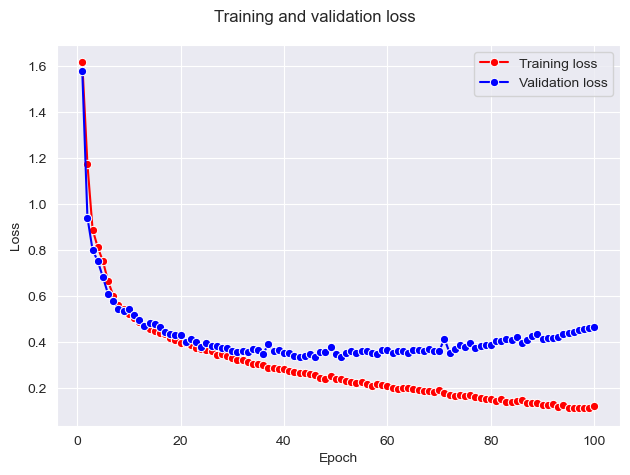

In [31]:
conv_nn.plot_loss()

In [32]:
def predict(model, test_loader):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.to(device)

    # Put model into evaluation mode
    model.eval()
    predictions = []
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        output = model(test_imgs)
        prediction = torch.max(output,1)[1]
        predictions.append(prediction.data.cpu().numpy())

    model.train()
    return np.concatenate(predictions)


In [33]:
# We load the early stopping model
saved_nn = CNN()
saved_nn.load_state_dict(torch.load('data/saved_model.pth'))


<All keys matched successfully>

In [34]:
# predicting
saved_nn_y_pred=predict(saved_nn, loaders['test'])
conv_y_pred = predict(conv_nn, loaders["test"])


# Comparing the two versions of the CNN

In [35]:
print("Early stopping CNN:\n",classification_report(y_true=y_test, 
                            y_pred=saved_nn_y_pred,
                            target_names=CLOTHING_TYPES.values()))
print()
print("Possibly overfitted CNN:\n",classification_report(y_true=y_test, 
                            y_pred=conv_y_pred,
                            target_names=CLOTHING_TYPES.values()))


Early stopping CNN:
               precision    recall  f1-score   support

 T-shirt/top       0.81      0.85      0.83      1000
     Trouser       0.97      0.97      0.97      1000
    Pullover       0.89      0.84      0.86      1000
       Dress       0.92      0.91      0.92      1000
       Shirt       0.73      0.73      0.73      1000

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000


Possibly overfitted CNN:
               precision    recall  f1-score   support

 T-shirt/top       0.84      0.82      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.86      0.88      0.87      1000
       Dress       0.92      0.93      0.92      1000
       Shirt       0.75      0.74      0.74      1000

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      

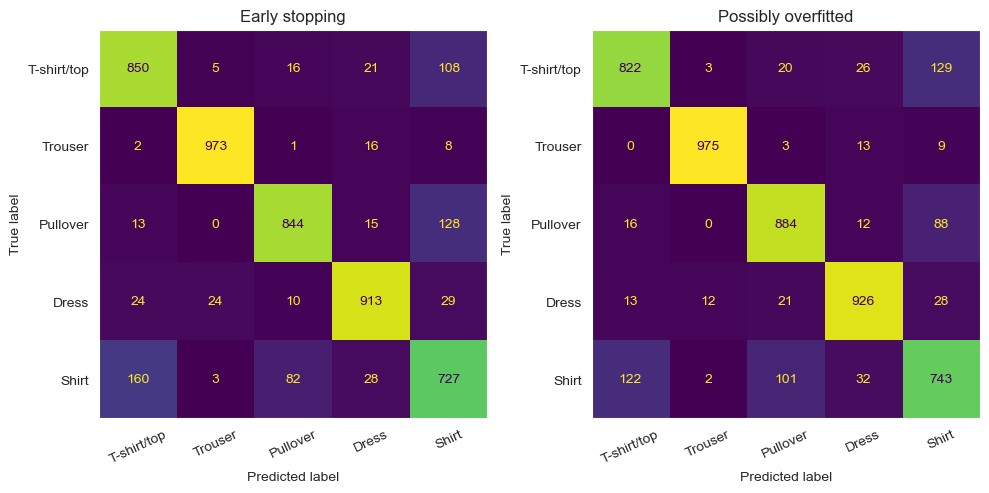

In [39]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=saved_nn_y_pred), 
                       display_labels=CLOTHING_TYPES.values()).plot(ax=ax[0], xticks_rotation=25,colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=conv_y_pred), 
                       display_labels=CLOTHING_TYPES.values()).plot(ax=ax[1], xticks_rotation=25, colorbar=False)

ax[0].grid(False)
ax[0].set_title("Early stopping")
ax[1].grid(False)
ax[1].set_title("Possibly overfitted")
fig.tight_layout()

We choose the early stopping method.

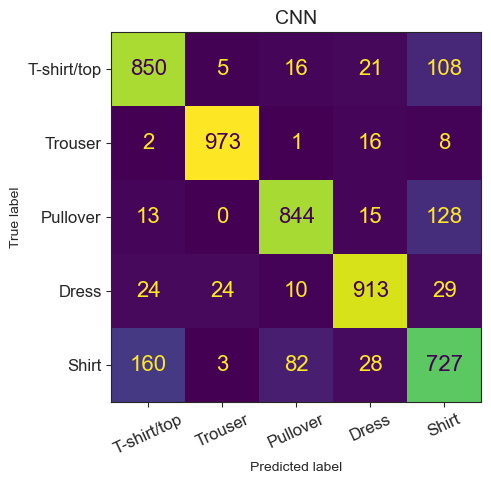

In [53]:
sns.set_style("ticks")
fig,ax = plt.subplots(ncols=1, figsize=(5,5))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=saved_nn_y_pred), 
                       display_labels=CLOTHING_TYPES.values()).plot(ax=ax, xticks_rotation=25,colorbar=False, text_kw={'fontsize': 16})
ax.grid(False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_title("CNN", fontsize=14)
fig.tight_layout()

# Visualizing filters

In [37]:
def get_conv_layers(cnn):

    model_weights = []
    conv_layers = []
    model_children = list(cnn.children())


    for child in model_children:
        if type(child) == nn.Conv2d:
            model_weights.append(child.weight)
            conv_layers.append(child)
        elif type(child) == nn.Sequential:
            for grandchild in child:
                if type(grandchild) == nn.Conv2d:
                    model_weights.append(grandchild.weight)
                    conv_layers.append(grandchild)

    return conv_layers, model_weights
            

conv_layers, model_weights = get_conv_layers(conv_nn)
                

# filter shapes (conv layer sizes)
for weight, conv in zip(model_weights,conv_layers):
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")


CONV: Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([6, 1, 5, 5])
CONV: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([16, 6, 5, 5])


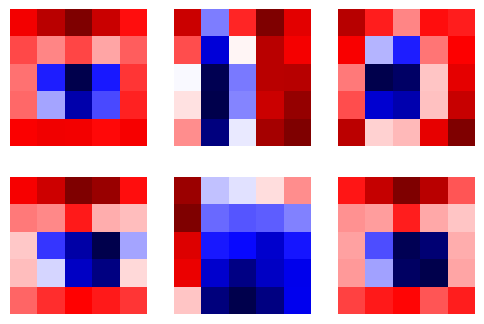

<Figure size 640x480 with 0 Axes>

In [332]:
# Visualizing first filters
cmap = plt.get_cmap("seismic_r")
plt.figure(figsize=(6,4))

for i, filter in enumerate(model_weights[0]):
    plt.subplot(2,3, i+1)
    plt.imshow(filter[0,:,:].detach().cpu().numpy(), cmap=cmap)
    plt.axis('off')
plt.show()
plt.tight_layout();

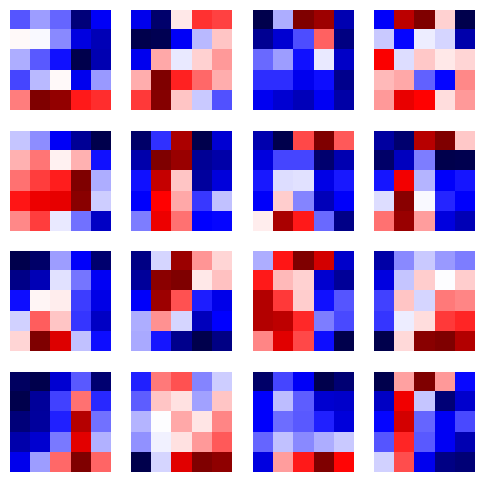

<Figure size 640x480 with 0 Axes>

In [333]:
# Visualizing second filters

plt.figure(figsize=(6,6))

for i, filter in enumerate(model_weights[1]):
    plt.subplot(4,4, i+1)
    plt.imshow(filter[0,:,:].detach().cpu().numpy(), cmap=cmap)
    plt.axis('off')
plt.show()
plt.tight_layout();

In [334]:
def plot_img_with_convolution(conv_layers,idx):
    cmap = plt.get_cmap("seismic_r")
    # Visualising feature maps
    example_img = to_tensor(np.float32(X_train[idx].reshape(28,28))).to(torch.device("mps" if torch.backends.mps.is_available() else "cpu"))

    # Create a mini model using only conv1

    model1 = nn.Sequential(conv_layers[0])

    output_conv1_convolution = model1(example_img)

    fig = plt.figure(figsize=(12,6))

    grid = gridspec.GridSpec(8, 16, figure=fig)

    # Creating the 2x3 subplot within the defined grid

    # left side (plots greyscale image)
    ax1 = fig.add_subplot(grid[2:6, :4])
    ax1.imshow(X_train[idx].reshape(28,28), cmap="grey")
    ax1.grid(False)
    ax1.set_title(f'Greyscale Image ({CLOTHING_TYPES[y_train[idx]]})')

    # Right side

    ax2 = fig.add_subplot(grid[:4, 4:8])
    ax2.imshow(output_conv1_convolution[0].detach().cpu().numpy(), cmap=cmap)
    ax2.grid(False)
    ax2.set_title('Filter 1')


    ax3 = fig.add_subplot(grid[:4, 8:12])
    ax3.imshow(output_conv1_convolution[1].detach().cpu().numpy(), cmap=cmap)
    ax3.grid(False)
    ax3.set_title('Filter 2')


    ax4 = fig.add_subplot(grid[:4, 12:16])
    ax4.imshow(output_conv1_convolution[2].detach().cpu().numpy(), cmap=cmap)
    ax4.grid(False)
    ax4.set_title('Filter 3')


    ax5 = fig.add_subplot(grid[4:, 4:8])
    ax5.imshow(output_conv1_convolution[3].detach().cpu().numpy(), cmap=cmap)
    ax5.grid(False)
    ax5.set_title('Filter 4')


    ax6 = fig.add_subplot(grid[4:, 8:12])
    ax6.imshow(output_conv1_convolution[4].detach().cpu().numpy(), cmap=cmap)
    ax6.grid(False)
    ax6.set_title('Filter 5')

    ax7 = fig.add_subplot(grid[4:, 12:16])
    ax7.imshow(output_conv1_convolution[5].detach().cpu().numpy(), cmap=cmap)
    ax7.grid(False)
    ax7.set_title('Filter 6')

    fig.tight_layout()



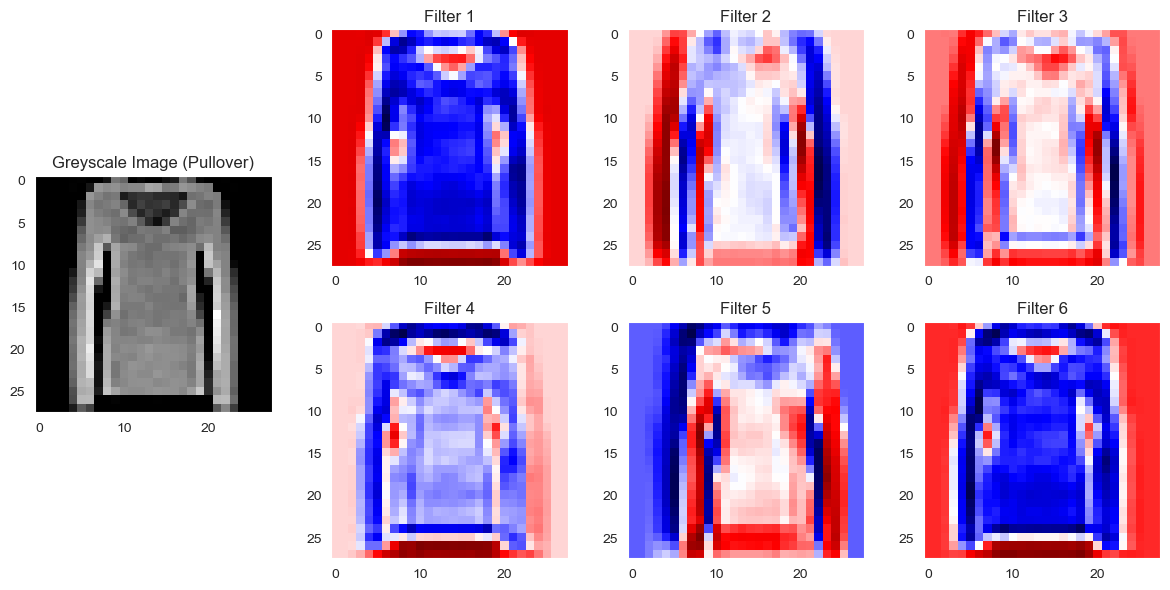

In [335]:
conv_layers_conv_nn, _ = get_conv_layers(conv_nn)
conv_layers_saved_nn, _ = get_conv_layers(saved_nn)

plot_img_with_convolution(conv_layers_conv_nn, 6)

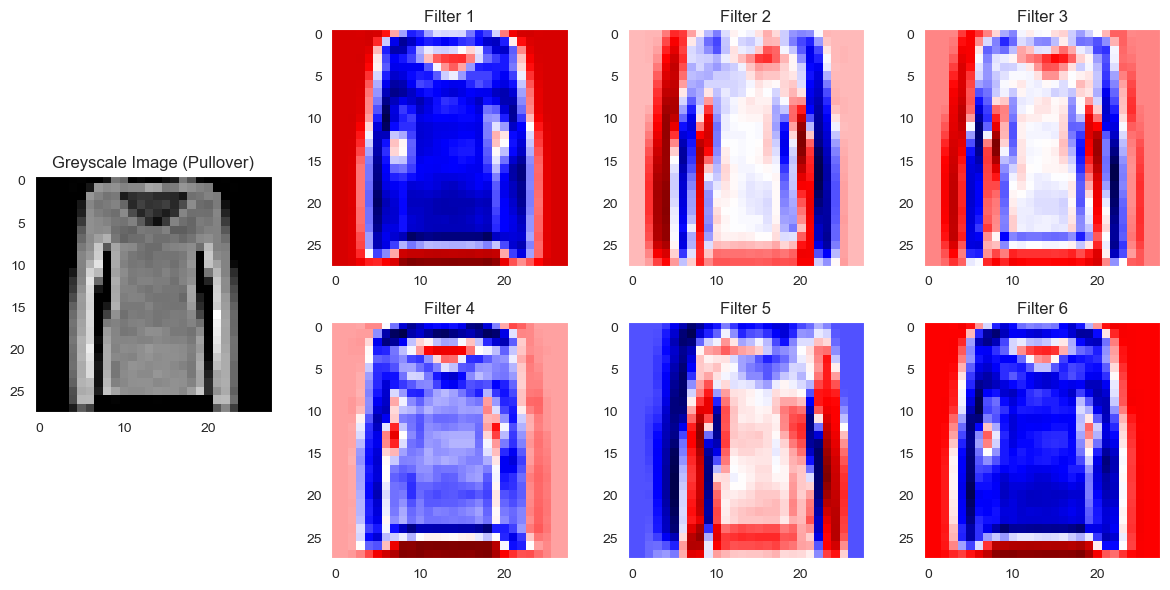

In [336]:
plot_img_with_convolution(conv_layers_saved_nn, 6)